# Main notebook

### Preprocessing

In [49]:
import pandas as pd 
import json 
import os
import random
from tqdm import tqdm 
import pickle 
from collections import defaultdict
from collections import Counter
from functions import *
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt 
from collections import Counter
import networkx as nx
from prettytable import PrettyTable

In [2]:
"""
Renaming the columns dataset
"""
df = pd.read_csv("data/wikigraph_reduced.csv", sep='\t') 
df.columns = ["Edges",'Source', 'Target']

In [3]:
df.head(5)

,Edges,Source,Target
0,796,95,1185516
1,909,108,1059989
2,910,108,1062426
3,911,108,1161925
4,1141,134,541222


In [4]:
"""
save renamed dataset into a csv file
"""
df.to_csv('data/dataset.csv', index=False)

In [5]:
"""
Looping over the txt file named "wiki-topcats-page-names.txt", 
we build a dictionary with key an integer and as value the name (as string) the name of the page. 
This index allows to work directly with page indexes.
keys: number of the page (article)
values: name of the page (article)
"""

p = open("data/wiki-topcats-page-names.txt", "r")
pages = {}
for pag in tqdm(p): 
    list_ = pag.split()[1:]
    aux = ' '.join(list_)
    pages[int(pag.split()[0])] = aux


1791489it [00:02, 752120.36it/s]


In [6]:
"""
usage of write/read pickle to save and read without re-run the cose
"""
write_pickle('data/pages.pkl', pages)

In [7]:
pages = read_pickle('data/pages.pkl')

In this step, we work with categories in two main steps: 
1. Since the provided dataset has been reduced from the entire one taking into account only pages belonging to categories with a length between 5000 and 30000, we considered categories within this margin.
2. Since each page (node) in the graph must belong to a single category, we created a structure in which each page in the graph (dictionary key) contains (as values) a list with all the categories to which that page belongs. 

In [8]:
"""
keys: number of the page (article)
values: [list of categories]
"""

# keys: number of the page (article)
# values: [list of categories]
cat = open("data/wiki-topcats-categories.txt", "r")
cat_per_pages = {}
for i in tqdm(cat):
    category = i.split()[0][9:-1]
    page_in_cat = list(map(int, i.split()[1:]))

    if len(page_in_cat) >5000 and len(page_in_cat) < 30000:
        for x in page_in_cat:
            if x not in cat_per_pages:
                a= []
                a.append(category)
                cat_per_pages[x]=a
            else: 
                aux = list(cat_per_pages[x])
                aux.append(category)
                cat_per_pages[x]= aux

17364it [00:01, 13840.95it/s]


As mentioned above, since a page must belong to only one category, the above structure allows us to choose only one category per page by choosing one randomly. 

In [9]:
"""
keys: number of the page (article)
values: category chosen at random and referring to that page
"""
one_cat_per_pages = {}
for key, elem in tqdm(cat_per_pages.items()):
    one_cat_per_pages[key] = random.choices(elem, k = 1)


100%|██████████| 149794/149794 [00:00<00:00, 450596.18it/s]


In [10]:
write_pickle('data/one_cat_per_pages.pkl', one_cat_per_pages)

In [11]:
one_cat_per_pages = read_pickle('data/one_cat_per_pages.pkl')

Finally, we create a last dictionary that takes us back to the initial state, i.e. 
the name of the category and the pages (integers) in that category. 
This time, each page is linked to a single category.

In [12]:
"""
keys: category chosen at random 
values: number of the pages (article) referring to the category
"""
categories_red = {}
for key, elem in tqdm(one_cat_per_pages.items()):

    if elem[0] not in categories_red:
            a= []
            a.append(key)
            categories_red[elem[0]]=a
    else: 
            aux = list(categories_red[elem[0]])
            aux.append(key)
            categories_red[elem[0]]= aux


100%|██████████| 149794/149794 [00:02<00:00, 70069.10it/s]


In [13]:
write_pickle('data/categories_red.pkl', categories_red)

In [14]:
categories_red = read_pickle('data/categories_red.pkl')

# RQ1

Build the graph G=(V, E), where V is the set of articles and E the hyperlinks among them. Then, provide its basic information:

Is the graph directed?
How many articles are we considering?
How many hyperlinks between pages exist?
Compute the average number of links in an arbitrary page. What is the graph density? Do you believe that the graph is dense or sparse? Is the graph dense?
Visualize the nodes' degree distribution

In [15]:
data = pd.read_csv('data/dataset.csv')

Creation of the Graph

In [16]:
graph = get_graph_dictionary(data)

100%|██████████| 98343/98343 [00:21<00:00, 4531.54it/s] 


In [17]:
write_pickle('data/graph.pkl', graph)

In [18]:
graph = read_pickle('data/graph.pkl')

Initialization of the Class Graph

In [19]:
g = Graph(graph)

### Is the graph directed?

The graph is directed by construction, in fact it is composed of Source nodes and Target nodes. 
These nodes may repeat themselves, but are connected by single edges. 
Furthermore, it is possible to prove this by considering the adjacency matrix, in fact in general a graph can be represented by a sparse matrix. This means that the adjacency matrix of an directed graph is not necessarily symmetric. As shown below, the matrix is not symmetric. 

In [20]:
mat = sp.lil_matrix((max(g.vertices())+1,max(g.vertices())+1), dtype=int)
# method to check if the matrix is symmetric
rows, cols = IsSymmetric(mat, g)
if np.cumsum((mat[cols, rows] == mat[rows, cols]).A)[-1] == mat[cols, rows].shape[1]:
    print('Is symmetric')
else:
    print('No symmetric')

/Users/domenicospoto/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/ipykernel_launcher.py:4: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  after removing the cwd from sys.path.


No symmetric


### How many articles are we considering?

We considered both Sources and Targets and took the unique values. This gives us the value of the total pages. 

In [21]:
print("Aricles of the graph:")
print(len(g.vertices()))

Aricles of the graph:
98343


### How many hyperlinks between pages exist?

In [22]:
print("Hyperlinks of the graph:")
print(len(g.edges()))

Hyperlinks of the graph:
483094


### Compute the average number of links in an arbitrary page. What is the graph density? Do you believe that the graph is dense or sparse? Is the graph dense?

In [23]:
"""
take only the first 100  pages and compute the average number of linkes per page
"""
list_ = []
for i in range(100):
    list_.append(average_number_pages1(g))
    avg = sum(list_)/len(list_)
print(avg)

4.51


Here we compute the density of the graph. 
Since our graph is directed, we can compute the density as follows:
    $$D = \frac{\lvert{E}\rvert}{2\binom{\lvert{V}\rvert}{2}} = \frac{\lvert{E}\rvert}{\lvert{V}\rvert(\lvert{V}\rvert - 1)}$$

In [24]:
density_graph(g)

4.9951571365597335e-05

From the results, we may say that our graph is sparse because the density is close to 0.

### Visualize the nodes' degree distribution

#### In degree Distribution 

At this point we have calculated the in degree distribution, i.e. the number of links entering a node. 
As the plot shows many nodes have a low number of in-links.  

In [25]:
concat = [data['Source'], data['Target']]
df_concat = pd.concat(concat)
all_nodes = list(df_concat.unique())

In [26]:
d_aux = dict.fromkeys(all_nodes, 0)
only_target_node = list(data.Target)
for node in tqdm(only_target_node):
    d_aux[node] +=1

100%|██████████| 483094/483094 [00:00<00:00, 1093403.03it/s]


In [27]:
in_deg = Counter(sorted(list(d_aux.values())))
y_in = np.array(list(in_deg.values()))
y_in = y_in/len(g.vertices())
x_in = list(in_deg.keys())

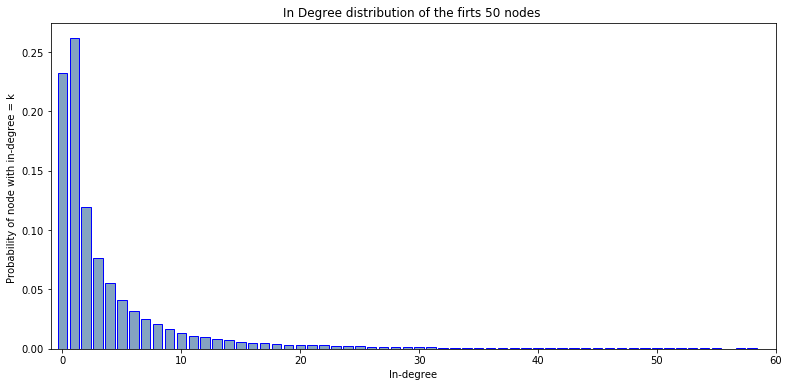

In [28]:
plt.figure(figsize=(13,6))
plt.bar(x_in , y_in,
        color=(0.2, 0.4, 0.6, 0.6),
        edgecolor='blue')
plt.title("In Degree distribution of the firts 50 nodes ")
plt.xlabel("In-degree")
plt.ylabel("Probability of node with in-degree = k ")
plt.xlim(-1, 60)
plt.show()

#### Out-Degree

Out-degree distribution is the numer of links that go out from an vertex. 
In this case we computed this value considering the lenght of the list of a source node. 

In [29]:
out_deg_list = []
for key,items in tqdm(g.graph_d.items()):
    if isinstance(g.graph_d[key], list):
         out_deg_list.append(len(g.graph_d[key]))
    elif (isinstance(g.graph_d[key], int)): 
        out_deg_list.append(1) 
out_deg = Counter(sorted(out_deg_list))
x_out = list(out_deg.keys())
y_out =  np.array(list(out_deg.values()))/ len(g.vertices())

100%|██████████| 98343/98343 [00:00<00:00, 1120274.09it/s]


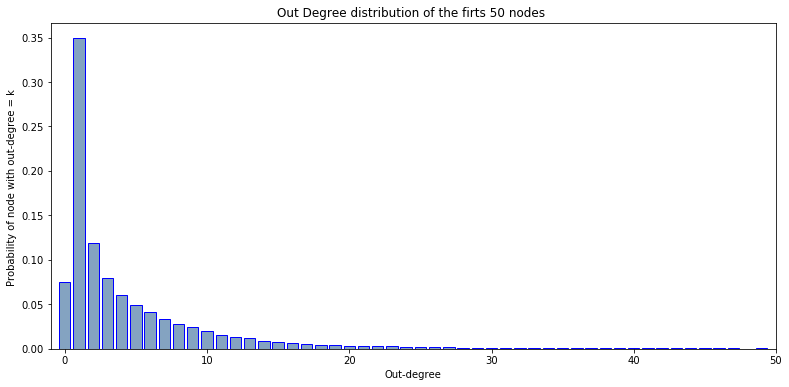

In [30]:
plt.figure(figsize=(13,6))
plt.bar(x_out, y_out,
        color=(0.2, 0.4, 0.6, 0.6),
        edgecolor='blue')
plt.title("Out Degree distribution of the firts 50 nodes ")
plt.xlabel("Out-degree")
plt.ylabel("Probability of node with out-degree = k ")
plt.xlim(-1, 50)
plt.show()

# RQ2

Define a function that takes in input:

A page v
A number of clicks d
and returns the set of all pages that a user can reach within d clicks.

In [31]:
dic = defaultdict(list)  # Creating default dictionary to store Source as key and Value as Target
for key,value in zip(data['Source'],data['Target']): 
    dic[str(key)].append(str(value))

Given the starting page, this function returns all the possible pages reached in n clicks.

In [32]:
try:
    page = input(" Enter page number ")
    click = input(" Enter number of clicks ")
    if page!='' or click!='':
        total_pages = pages_reached(page,int(click),dic)
        if len(total_pages)!=0:
            print("User can reach {} pages after {} clicks".format(len(total_pages),click))
        else:
            print("There is no link for this page, Kindly try with another page")
    else:
        print(" *********** Kindly provide valid input  **********")
except ValueError:
    print("No valid input! Please try again ...")

 Enter page number 108
 Enter number of clicks 2
User can reach 44 pages after 2 clicks


# RQ3

Define a function that takes in input:
- A category C
- A set of pages in C, p = {p1, ..., pn}

and returns the minimum number of clicks required to reach all pages in p, starting from the page v, corresponding to the most central article, according to the in-degree centrality, in C.

In [33]:
minimum_number_clicks(g.graph_d, categories_red, data)

Write the category
English_footballers

Write the set of pages in the category chosen separated by a ',':
48718, 75321, 28961

Reached vertex are: [75321, 48718]
Minimum number of clicks, from most central article 82082 to reach the set of pages, is 75752.
Not possible to reach [28961]


Within the function "minimum_number_clicks", we built the function called "most_central_article" which looks for the most central article in the category chosen. As measure of centrality we used the in-degree centrality to get in-degree values of each vertex in the chosen category.

Since we are using the Breadth First Search to search for all the neighbors close to the most central article, at worst we can have a time complexity of O(V+E) where V is number of vertices in the graph and E is number of edges in the graph. Keep in mind that not all the vertices are reachable from the most central article, so there can be cases where the articles chosen are not possible to reach.

# RQ4

Given in input two categories: C1 and C2, we get the subgraph induced by all the articles in the two categories.

Let v and u two arbitrary pages in the subgraph. What is the minimum set of hyperlinks one can remove to disconnect u and v?

In this question we were asked to implement a function that, given two categories as input, would return the subgraph induced by all the pages belonging to those two categories.

Our reasoning in creating the function below was that the best course of action would be to consider all those pages that could be found in the "source" and "target" columns of the main dataset, that being ds. In this way, we could avoid selecting many of those pages found in these categories that have no links to any other page. So in the cat_subgraph function we firstly selected all the pages belonging to the two categories and then created a subset of the main dataset, taking into account only the pages belonging to edges that either connect the two categories or are within the categories themselves.

In [34]:
sub_graph = cat_subgraph('Main_Belt_asteroids', 
                         'Asteroids_named_for_people', 
                         categories_red, 
                         data)

100%|██████████| 10923/10923 [00:01<00:00, 5784.14it/s]


Once the structure of the subgraph is computed as a dictionary, we can apply the Graph class to it.

In [35]:
sub_g = Graph(sub_graph)

In [36]:
for key,val in sub_graph.items():
    if isinstance(sub_graph[key], int):
        sub_graph[key] = [sub_graph[key]]

#### second function

For the second question of this request, we created two additional functions. The first one finds all the hyperlinks that connect the two nodes given as input, within the subgraph of their categories.

It must be noted that, because of the preprocessing, not every pair of nodes has a meaningful output for this function. This is because many paths are missing in our dataframe, so that it is not possible to go from any node to any other node in the way we would in the complete Wikipedia. In fact, we observed that most of the nodes that have links are actually part of clusters of nodes, that is group of nodes that are connected to each other through paths. One such cluster is found as the output of this function.

In [37]:
find_hyperlinks(sub_graph, 865445, 865449)

[[865445, 865447, 865446, 865449],
 [865445, 865447, 865449],
 [865445, 865446, 865447, 865449],
 [865445, 865446, 865449],
 [865445, 865449]]

The second function returns the amount of paths found, which comprises the minimum number of links that need to be cut in order to disconnect the two nodes.

In [38]:
min_hyperlinks(sub_graph, 865445, 865449)

5

# RQ5

For the fifth question we had to write a function that would return the distance between a category given as input and every other category in our dataframe.

As previously stated, because of the preprocessing and limitedness of the dataframe, many of the paths between nodes are missing, so that it is not possible to draw a complete path between any pair of nodes. For this reason, in the final output many distances are missing.


Since the computational time for this operation might be high, we have considered some examples for the following categories as tests. 
Since the categories have been assigned to the pages randomly, there could be several categories.  

In [39]:
t = PrettyTable(['Avaible Categories'])
for key,elem in categories_red.items():
    t.add_row([key])
print(t)

+---------------------------------------------------------------------+
|                          Avaible Categories                         |
+---------------------------------------------------------------------+
|                         English_footballers                         |
|                        Year_of_birth_missing                        |
|                     The_Football_League_players                     |
|                   Association_football_midfielders                  |
|                    Association_football_forwards                    |
|                    Association_football_defenders                   |
|                        Year_of_death_missing                        |
|                Place_of_birth_missing_(living_people)               |
| Members_of_the_United_Kingdom_Parliament_for_English_constituencies |
|                      Harvard_University_alumni                      |
|                         American_film_actors                  

In [42]:
score = distances_from_category(input(),categories_red, data, all_nodes)

Association_football_forwards


 76%|███████▌  | 3698/4897 [00:01<00:00, 3385.59it/s]


100%|██████████| 3776/3776 [00:00<00:00, 4503.52it/s]
/Users/domenicospoto/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/domenicospoto/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 9323/9323 [00:02<00:00, 4477.45it/s]
/Users/domenicospoto/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/domenicospoto/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1685/1685 [00:00<00:00, 4671.37it/s]
/Users/domenicospoto/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/numpy/co

In [43]:
pretty_table(score)

+---------------------------------------------------------------------+----------+
|                              Categories                             | Distance |
+---------------------------------------------------------------------+----------+
|                      American_television_actors                     |   1.0    |
|                    Association_football_defenders                   |   1.0    |
|                   Association_football_midfielders                  |   1.0    |
|                         English_footballers                         |   1.0    |
|                     The_Football_League_players                     |   1.0    |
|                         American_film_actors                        |   5.0    |
|                    Major_League_Baseball_pitchers                   |   5.0    |
|                             Debut_albums                            |   6.0    |
| Members_of_the_United_Kingdom_Parliament_for_English_constituencies |   6.0    |
|   

We can see for the example given, the greater the correlation between the pages, the smaller the distance. 

Here, for the sake of consistency, we saved everything in a pickle file and iterated over all categories. This is just a fast example of computing the distance from a category to the remaining ones.

In [45]:
score_categories(input())

Association_football_forwards
+---------------------------------------------------------------------+----------+
|                              Categories                             | Distance |
+---------------------------------------------------------------------+----------+
|                      American_television_actors                     |   1.0    |
|                   Association_football_midfielders                  |   1.0    |
|                         English_footballers                         |   1.0    |
|                     The_Football_League_players                     |   1.0    |
|                    Association_football_defenders                   |   2.0    |
|                        English-language_films                       |   4.0    |
|                         American_film_actors                        |   5.0    |
|                            American_films                           |   5.0    |
|                    Major_League_Baseball_pitchers      

# RQ6

Write a function that sorts the categories in the graph according to their PageRank (PR). For this task you need to model the network of categories such that you can apply the PR algorithm.

In [46]:
inbound = inbound(data) #initialize the function
outbound = out_bound(g) #initialize the function

100%|██████████| 98343/98343 [01:08<00:00, 1444.70it/s]


In [47]:
rank = page_rank(100, categories_red, inbound, outbound) # implementation of the Page Rank algorithm

100%|██████████| 21/21 [00:20<00:00,  1.02it/s]


In [52]:
pretty_table_2(rank)

+---------------------------------------------------------------------+------------------------+-----------+
|                              Categories                             |         Score          | Page Rank |
+---------------------------------------------------------------------+------------------------+-----------+
|                         American_film_actors                        | 9.582192715195594e-20  |     1     |
|                        English-language_films                       | 0.0001281262812628126  |     2     |
|                            American_films                           | 0.0001960413966484085  |     3     |
|                      American_television_actors                     | 0.00021240441801189465 |     4     |
|                             Debut_albums                            | 0.00023806689679800025 |     5     |
|                Place_of_birth_missing_(living_people)               | 0.0003146993622342494  |     6     |
|                  

The category with highest score is the "Main_Belt_asteroids" and the lowest score is "American_film_actors".